In [1]:
# !pip install -U fastbook

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastai import *
from fastai.vision.core import *
from fastai.vision.all import *
from fastdownload import *

In [4]:
from PIL import Image
from tqdm import tqdm

In [5]:
import pandas as pd
import numpy as np

In [6]:
import torch
import random

# download data

In [7]:
DIR_PETS = untar_data(URLs.PETS)
DIR_PETS

Path('/home/jovyan/.fastai/data/oxford-iiit-pet')

In [8]:
DIR_PETS.ls()

(#2) [Path('/home/jovyan/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/jovyan/.fastai/data/oxford-iiit-pet/images')]

### check images size

In [9]:
im_dim = []
for im_fname in get_image_files(DIR_PETS):
    im = Image.open(im_fname)
    im_dim.append(im.size)
    
im_dim = np.array(im_dim)
print(f'avg size: {im_dim.mean(axis=0)}')
print(f'min size: {im_dim.min(axis=0)}')
print(f'max size: {im_dim.max(axis=0)}')

avg size: [436.74519621 390.91366712]
min size: [114 103]
max size: [3264 2606]


# input transformation

In [10]:
grizzly_url = 'http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg'
download_url(grizzly_url, dest='grizzly.jpg')

Path('grizzly.jpg')

## Note:

`fastai` transformation (apparently) requires to use the `PILImage` object (I guess they wanted some extra sugar on top of the raw PIL images?)

I found this based on the [documentation notebook](https://github.com/fastai/fastai/blob/master/nbs/09_vision.augment.ipynb)

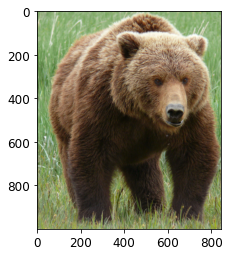

In [11]:
im = PILImage.create(Path('./grizzly.jpg'))
plt.imshow(im)

## Note:

All transformations are random, so we set the seed to have a reproducible behavior

In [12]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

/srv/conda/envs/saturn/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


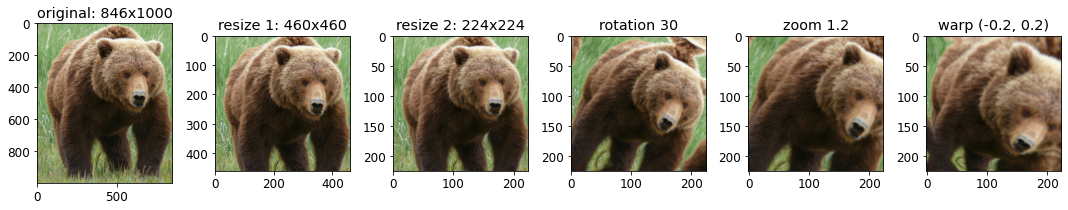

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,5))

### original
ax = axes[0]
ax.imshow(im)
width, height = im.size
ax.set_title(f'original: {width}x{height}')

### first resize
ax = axes[1]
resize = Resize(460)
x0 = resize(im)
ax.imshow(x0)
ax.set_title('resize 1: 460x460')

### second resize
#notes: we need to put color channels first
#       and add batch dimension first
fake_batch = np.array(x0).transpose(2,0,1) 
fake_batch = torch.tensor(fake_batch, dtype=torch.float)
fake_batch = fake_batch.unsqueeze(dim=0)
fake_batch = TensorImage(fake_batch)
# now we can resize, but we need some 
# dataprep to plot
x1 = fake_batch.affine_coord(sz=224)
ax = axes[2]
ax.imshow(x1[0].int().numpy().transpose(1,2,0))
ax.set_title('resize 2: 224x224')

### rotation
x2 = x1.rotate(draw=30, p=1.)
ax = axes[3]
ax.imshow(x2[0].int().numpy().transpose(1,2,0))
ax.set_title('rotation 30')

### zoom
x3 = x2.zoom(draw=1.2, p=1.)
ax = axes[4]
ax.imshow(x3[0].int().numpy().transpose(1,2,0))
ax.set_title('zoom 1.2')

### warp
x4 = x3.warp(draw_x=-0.2, draw_y=0.2, p=1.)
ax = axes[5]
ax.imshow(x4[0].int().numpy().transpose(1,2,0))
ax.set_title('warp (-0.2, 0.2)')


plt.tight_layout()

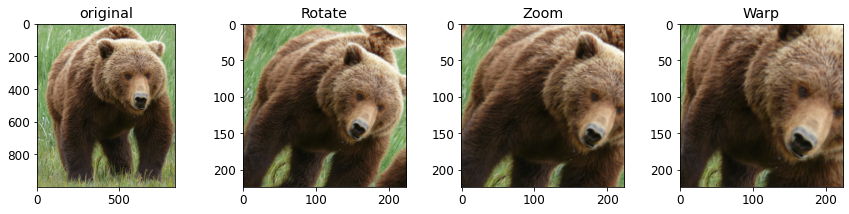

In [14]:
transformations = [
    Rotate(draw=30, p=1, size=224), 
    Zoom(draw=1.2, p=1., size=224),
    Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)
]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,3))

ax = axes[0]
ax.imshow(im)
ax.set_title('original')

for idx, ax in enumerate(axes[1:], start=1):
    np.random.seed(101)
    torch.manual_seed(101)

    transformations_to_use = transformations[0:idx]
    tfms = setup_aug_tfms(transformations_to_use)
    fastai_x = Pipeline(tfms)(fake_batch)
    ax.imshow(fastai_x[0].int().numpy().transpose(1,2,0))
    ax.set_title(transformations_to_use[-1].__class__.__name__)


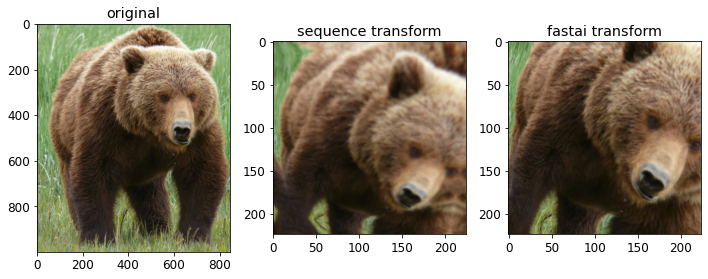

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

###
ax = axes[0]
ax.imshow(im)
ax.set_title('original')

###
ax = axes[1]
ax.imshow(x4[0].int().numpy().transpose(1,2,0))
ax.set_title('sequence transform')

###
ax = axes[2]
ax.imshow(fastai_x[0].int().numpy().transpose(1,2,0))
ax.set_title('fastai transform')

plt.tight_layout()

## Note:

Not completely clear to me what is going on underneath. I didn't find solid tutorials/discussions about the underlining mechanichs, and the source code related to `Pipeline()` is based on a hierarchy of objects, which requires extra time to really understand. 

At the time of writing, by best guess is that the transformations are going to be (somehow) "merged" into a single operation

# Extra theory notes (by developing info in the chapter)

## relationship between sigmoid and softmax

At page 197, the book says 

    ...we would be able to use sigmoid directly on the two-activation version of our neural net. And indeed we can! We can just take the difference between the neural net activations, because that reflect how much more sure we are of the input being a 3 than a 7...
    
In other words, it is saying that in a binary classifier, $softmax(x) = sigmoid(x_1 - x_2)$

Let's demonstrate this!

- $\Large sigmoid(x_1)=\LARGE\frac{1}{1+e^{-x_1}}$
$ \Large = \LARGE\frac{1}{1+e^{-x_1}} \cdot \frac{e^{-x_1}}{e^{-x_1}}$
$ \Large = \LARGE\frac{e^{x_1}}{e^{x_1} + 1}$ 

- $\Large softmax(x_1)=\LARGE\frac{e^{x_1}}{\sum_i e^{x_i}}$

So, in the case of a binary classifier

$\Large sigmoid(x_1 - x_2)=\LARGE\frac{e^{(x_1-x_2)}}{e^{(x_1-x_2)}+1}$
$ = \LARGE\frac{e^{(x_1-x_2)}}{e^{(x_1-x_2)}+1} \cdot \frac{e^{x_2}}{e^{x_2}}$
$ = \LARGE\frac{e^{x_1}}{e^{x_1} + e^{x_2}}$
$ = \Large softmax(x_1)$

In other words, in a binary classifier, softmax is equivalent to the sigmoid of the difference of the activations (i.e., the output values of the neural network)

## gradient of binary cross entropy loss

The "Sylvain Says" note on page 203 says 

    ... The gradient of that cross_entropy(a,b) = softmax(a) - b. Since softmax(a) is the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target...

First of all, in this context $a$ are the activation of the last layer (before the final softmax), and $b$ the target values

Second, let's demonstrate the equality mentioned in the note

$\Large crossentropy([x_1, x_2], [y_1, y_2])$

$ \Large = - [y_1 \log(p_1) + y_2 \log(p_2)]$

$ \Large = - [y_1 \log(softmax(x_1) + y_2 \log(softmax(x_2))]$

$ \Large = - [y_1 \log(\frac{e^{x_1}}{\sum_i e^{x_i}}) + y_2 \log(\frac{e^{x_2}}{\sum_i e^{x_i}})]$

$ \Large = - [y_1 (\log e^{x_1} - \log \sum_i e^{x_i}) + y_2 (\log e^{x_2} - \log \sum_i e^{x_i} ]$

$ \Large = - [y_1 (x_1 - \log \sum_i e^{x_i}) + y_2 (x_2 - \log \sum_i e^{x_i}) ]$

Now, if we derive with respect to $x_1$ we obtain

$ \Large - [y_1 (1 - \frac{1}{\sum_i e^{x_i}} \cdot e^{x_1}) + y_2(0 - \frac{1}{\sum_i e^{x_i}} \cdot e^{x_1})] $


$ \Large = - [y_1 (1-softmax(x_1)) - y_2 softmax(x_1)] $

$ \Large = y_1 (softmax(x_1)-1) + y_2 softmax(x_1) $

$ \Large = y_1 (softmax(x_1) - 1) + (1-y_1) softmax(x_1) $

$ \Large = y_1 \cdot softmax(x_1) - y_1 + softmax(x_1) - y_1 softmax(x_1)$

$ \Large = softmax(x_1) - y_1 $

In other words
- The the gradient is proportional to the delta between the class probability and the expected label
- Such __delta is the prediction error__, i.e., the same mechanisms we used in chapter 4 when coding our loss "manually"
- This is because our labels are binary, that is $y_i$ can only be 0 or 1
- So, written in this way, we obtain the same transformation we did manually in chapter 4 (we were using $p$ or $1-p$ depending on the class value)

## Note:

Recall that the gradient update imply a subtraction, i.e., `weights.data -= lr * weights.grad`. 

Also, in a binary classifier $y\in \{0,1\}$. 

Thus, notice now the sign of the gradient with respect to the label:
- If $y_1 = 0$, the gradient is positive (i.e., increasing slope), thus we need to move towards the left of the gradient
- If $y_1 = 1$, the gradient is negative (i.e., decreasing slope), thus we need to move towards the right of the gradient

# extract animal breeds label

## Notes

The book introduces here regular expressions using `re.findall(r'(.+)_\d+.jpg')`

I'm not against using regext, but I think in this context are __NOT__ needed. At the very least, the regex used implies strong assumptions, i.e., the opposite of the argument used in the book:
- Notice that `.jpg`; actuall means `?jpg`. It should have been specified as `'\.jpg'`. For instance, try running `re.findall(r'(.+)_\d+.jpg', 'abcd_1234xjpg')`
- It is not so uncommon to find files capitalized, especially if datasets are generated with Windows. This requires to add `flags=re.IGNORECASE` to `re.findall()`
- The dataset might contain files with different format than `jpg`
- JPEG files can be expressed also as `.jpeg` (not only `.jpg`)

There might be reasons to justify the regex used, and probably they are brought up just to hook the reader to investigate more into regex in general.

However, given the very simple scenario, using regex (and the selected regex) is probably too much. 

A much simpler alternative is the `.rsplit()` method of string objects 

In [16]:
def get_breed(path):
    return path.name.rsplit('_', 1)[0]

[ get_breed(path) for path in  get_files(DIR_PETS / 'images')[:5]]

['shiba_inu', 'Birman', 'great_pyrenees', 'yorkshire_terrier', 'Birman']

# samples per class

In [17]:
# I guess fastai has an API for doing this
# ...but at this stage I didn't discover it yet

from collections import Counter

In [18]:
cnt = Counter(get_breed(fname) for fname in get_image_files(DIR_PETS/'images'))

In [19]:
cnt.most_common()

[('shiba_inu', 200),
 ('Birman', 200),
 ('great_pyrenees', 200),
 ('yorkshire_terrier', 200),
 ('german_shorthaired', 200),
 ('beagle', 200),
 ('basset_hound', 200),
 ('english_setter', 200),
 ('keeshond', 200),
 ('Bombay', 200),
 ('Maine_Coon', 200),
 ('american_pit_bull_terrier', 200),
 ('Bengal', 200),
 ('pug', 200),
 ('Persian', 200),
 ('american_bulldog', 200),
 ('pomeranian', 200),
 ('Abyssinian', 200),
 ('newfoundland', 200),
 ('Ragdoll', 200),
 ('Russian_Blue', 200),
 ('leonberger', 200),
 ('British_Shorthair', 200),
 ('havanese', 200),
 ('Sphynx', 200),
 ('english_cocker_spaniel', 200),
 ('boxer', 200),
 ('Egyptian_Mau', 200),
 ('wheaten_terrier', 200),
 ('saint_bernard', 200),
 ('Siamese', 200),
 ('japanese_chin', 200),
 ('chihuahua', 200),
 ('samoyed', 200),
 ('miniature_pinscher', 200),
 ('scottish_terrier', 199),
 ('staffordshire_bull_terrier', 191)]

# loader

In [20]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

In [21]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    item_tfms=Resize(446),
    batch_tfms=aug_transforms(size=224, min_scale=0.7),
    get_items=get_image_files,
    get_y=get_breed,
)

In [22]:
loader = datablock.dataloaders(DIR_PETS / 'images', bs=64, shuffle=True)

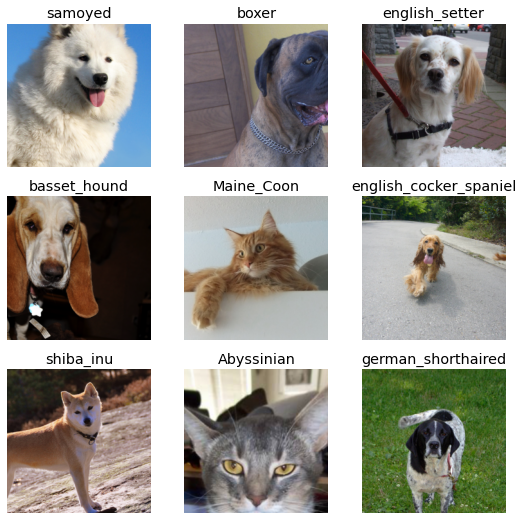

In [23]:
loader.train.show_batch()

In [25]:
## train the model using a GPU
## the following was executed using NVIDIA QUATRO M4000 (over paperspace)

In [26]:
learner = cnn_learner(loader, resnet34, lr=0.01, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/srv/conda/envs/saturn/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [27]:
learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.455096,0.387314,0.138024,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.473570,0.309693,0.101489,00:54
1,0.420942,0.386058,0.111637,00:54
2,0.314628,0.271126,0.084574,00:54
3,0.187533,0.208037,0.068336,00:54
4,0.128958,0.204698,0.067659,00:54


## Note

Save the model (to avoid retraining it, since the operation can be slow)

Watchout that (oddly enough) fastai always save under `/models`, no matter the path specified 

In [28]:
learner.save('./chapter05_pet_breeds.pkl')

Path('models/chapter05_pet_breeds.pkl.pth')

In [29]:
learner2 = cnn_learner(loader, resnet34, lr=0.01, metrics=error_rate)
learner2.load('./chapter05_pet_breeds.pkl')

# Check misclassifications

In [30]:
interp = ClassificationInterpretation.from_learner(learner2)

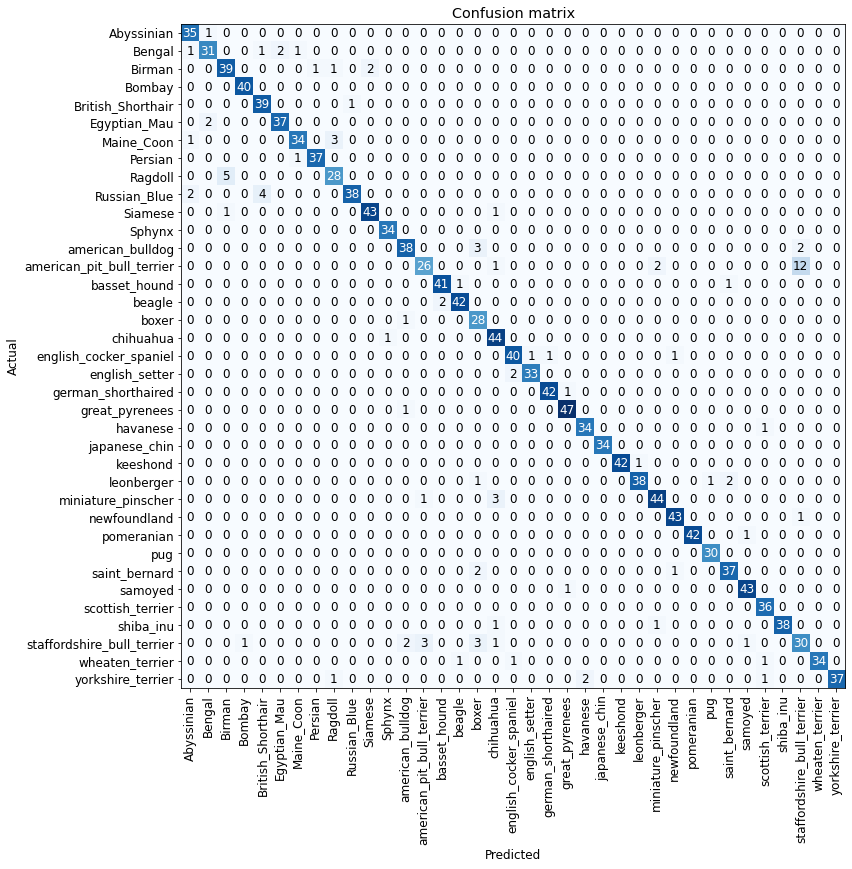

In [31]:
interp.plot_confusion_matrix(figsize=(12,12))

I don't really like seeing the zeros, so let's replot the confusion matrix

In [32]:
_, y_pred = interp.preds.max(dim=1)

In [33]:
y_true = interp.targs

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [35]:
df = pd.DataFrame(
    confusion_matrix(y_true.numpy(), y_pred.numpy()), 
    index=interp.vocab,
    columns=interp.vocab
)

<AxesSubplot:>

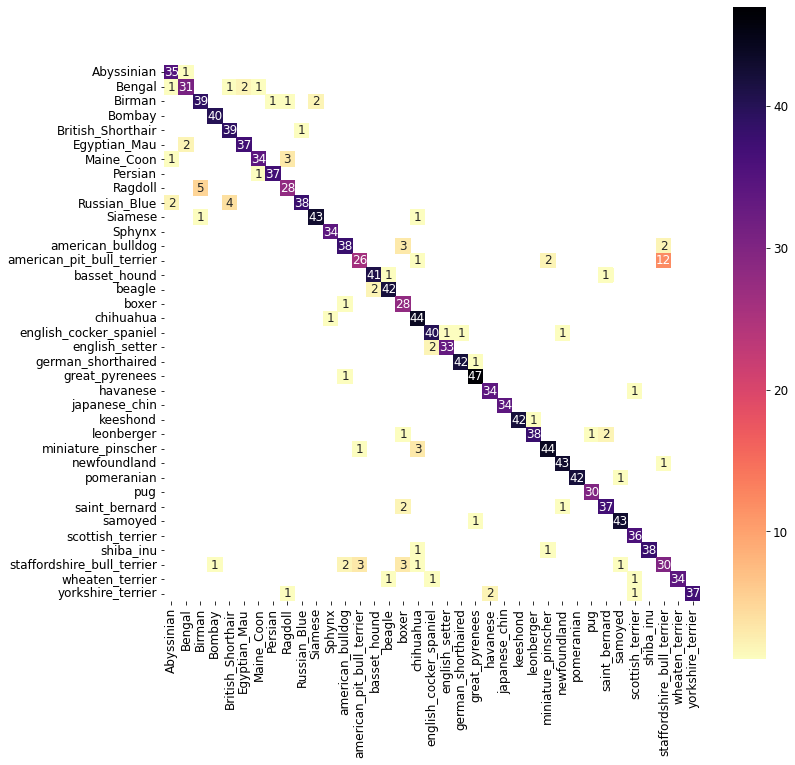

In [36]:
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(
    ax=ax,
    data = df.replace({0:np.nan}),
    annot=True,
    cmap='magma_r',
    square=True
)

Better, but let's remove the main diagonal so expose only the confusion

<AxesSubplot:>

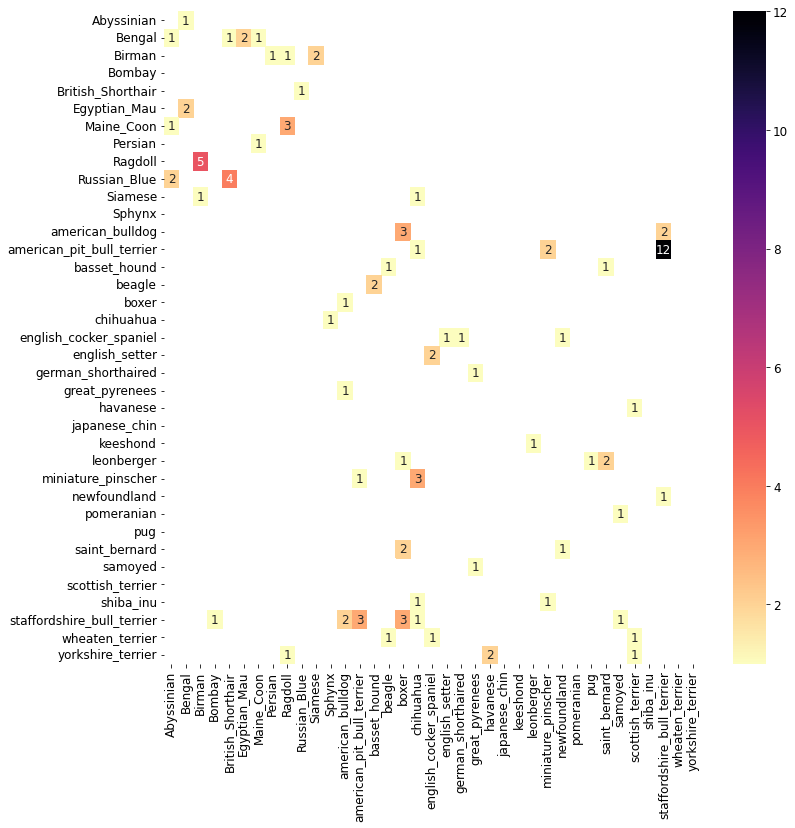

In [37]:
fig, ax = plt.subplots(figsize=(12,12))
# create a mask to remove the diagonal
df_mask = np.ones((df.shape[0], df.shape[0])) - np.identity(df.shape[0])
sns.heatmap(
    ax=ax,
    data = (df * df_mask).replace({0:np.nan}),
    annot=True,
    cmap='magma_r',
)

# Re-implementing the learning rate finder

## Note

Related to the note about the log scale

    ...the middle point between 1e-3 and 1e-2 is between 3e-3 and 4e-3. This is because we care mostly about the order of magnitude of the learning rate
    
Where this is coming from? It relates to the application to $\log$ (intended as $\log_10$)

- First of all, we are considering the range 0.001 and 0.01, which correspond to -3 and -2 on $\log$ scale
- The middle point then is -2.5
- This means we look for $\log x = -2.5$, which is $x = 10^{-2.5} = 0.0031622776601683794$

In [38]:
# just for repeatability

random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

In [39]:
learner = cnn_learner(loader, resnet34, lr=0.01, metrics=error_rate)

In [43]:
learner.model.train().cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [44]:
def lr_generator(start_lr, end_lr):
    lr = start_lr
    while lr <= end_lr:
        yield lr
        lr *= 2

In [45]:
loss_tracker = []
lr_tracker = list(lr_generator(start_lr=1e-10, end_lr=1.1))

for lr, (x, y) in tqdm(zip(lr_tracker, loader.train), total=len(lr_tracker)):
    y_pred = learner.model(x)
    loss = learner.loss_func(y_pred, y)
    
    learner.opt.set_hyper('lr', lr)
    
    learner.opt.zero_grad()
    loss.backward()
    learner.opt.step()
    
    loss_tracker.append(loss.item())

  6%|▌         | 2/34 [00:02<00:29,  1.10it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b33ff1160>
Traceback (most recent call last):
  File "/srv/conda/envs/saturn/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0b33ff1160>self._shutdown_workers()

  File "/srv/conda/envs/saturn/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
      File "/srv/conda/envs/saturn/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/saturn/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
if w.is_alive():
  File "/srv/conda/envs/saturn/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == o

Text(0, 0.5, 'loss')

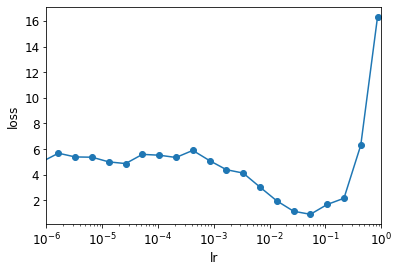

In [46]:
fig, ax = plt.subplots()
ax.plot(lr_tracker, loss_tracker, 'o-')
ax.semilogx()
ax.set_xlim(10e-7, 1)
ax.set_xlabel('lr')
ax.set_ylabel('loss')

### Note

The behavior is pretty close to the one from the book!

I came to the above implementation investigating the source code of `learner.lr_find()`. 

It is actually less straight forward than what one think, but it's there where I noticed the use of `.set_hyper()`. Apparently `learner.lr` is independent from the `learner.opt` parameters, namely `learner.opt.hyper`

In [47]:
learner.lr

0.01

In [48]:
lr_tracker[-1]

0.8589934592

In [49]:
learner.opt.hypers

(#3) [{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.8589934592, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.8589934592, 'mom': 0.9, 'eps': 1e-05},{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.8589934592, 'mom': 0.9, 'eps': 1e-05}]

## Investigating fine tuning, freezing, discriminative learning rate

In [50]:
learner.fine_tune??

Signature:
learner.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /srv/conda/envs/saturn/lib/python3.9/site-packages/fastai/callback/schedule.py
Type:      method


### Note

The fine tuning invoke the fit 1cycle, which is a special training policy (see this [fastai post](https://fastai1.fast.ai/callbacks.one_cycle.html)) found by Leslie Smith, which discovered also the learning rate finder algorithm.

It has to do on changing the *learning rate* and the *momentum* through the training epochs according to a specific logic. However, at this point of the book only the former has been introduced, so we should put a pin on this detail and circle back to it later on.

In [51]:
learner.fit_one_cycle??

Signature:
learner.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)
File:      /srv/conda/envs/saturn/lib/python3.9/site-packages/fastai/callback/schedule.py
Type:      method


## Single `lf_finder`, dual `lr_finder`, or discriminative learning rate

In [24]:
learner_default = cnn_learner(loader, resnet34, metrics=error_rate)

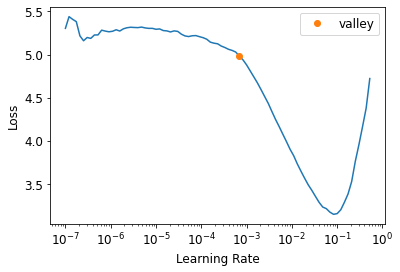

In [25]:
single_lr = learner_default.lr_find()

### train a model head for 3 cycles, and save it as baseline

In [28]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

learner_base = cnn_learner(loader, resnet34, lr=single_lr, metrics=error_rate)
learner_base.freeze()
learner_base.fit_one_cycle(3, single_lr.valley)

epoch,train_loss,valid_loss,error_rate,time
0,2.035394,0.376562,0.117050,00:42
1,0.783565,0.277378,0.083221,00:43
2,0.500191,0.270617,0.086604,00:43


In [29]:
learner_base.save('pet_bread_learner_base')

Path('models/pet_bread_learner_base.pth')

### single lr

In [36]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

learner_singlelr = cnn_learner(loader, resnet34, lr=single_lr, metrics=error_rate)
learner_singlelr.load('pet_bread_learner_base')

In [37]:
learner_singlelr.train();

learner_singlelr.unfreeze()
learner_singlelr.fit_one_cycle(10, lr_max=single_lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.488705,0.439304,0.130582,00:56
1,0.853436,1.787678,0.387686,00:57
2,0.957033,1.141586,0.297700,00:57
3,0.796508,0.948991,0.264547,00:57
4,0.629765,0.714725,0.197564,00:57
5,0.469834,0.457904,0.140054,00:57
6,0.328090,0.408447,0.125169,00:57
7,0.223406,0.351393,0.099459,00:57
8,0.146452,0.290831,0.081191,00:57
9,0.103717,0.271908,0.080514,00:57


### double lr

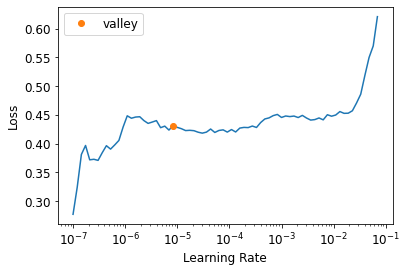

In [38]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

learner_doublelr = cnn_learner(loader, resnet34, lr=single_lr, metrics=error_rate)
learner_doublelr.load('pet_bread_learner_base')
learner_doublelr.train();

doublelr = learner_doublelr.lr_find()

In [39]:
learner_doublelr.unfreeze()
learner_doublelr.fit_one_cycle(10, doublelr)

epoch,train_loss,valid_loss,error_rate,time
0,0.448158,0.258622,0.085927,00:56
1,0.406899,0.248676,0.075778,00:56
2,0.399179,0.242123,0.076455,00:57
3,0.371485,0.229359,0.071719,00:57
4,0.342968,0.228643,0.071042,00:57
5,0.307065,0.222322,0.069012,00:57
6,0.297891,0.221198,0.066982,00:57
7,0.279454,0.215658,0.068336,00:57
8,0.273510,0.214729,0.069012,00:57
9,0.278570,0.214929,0.065629,00:57


### discriminative lr, using the value suggested by `lr_find()`

In [79]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

learner_discrim_default = cnn_learner(loader, resnet34, lr=single_lr, metrics=error_rate)
learner_discrim_default.load('pet_bread_learner_base')
learner_discrim_default.train();

In [80]:
learner_discrim_default.unfreeze()
learner_discrim_default.fit_one_cycle(10, slice(doublelr.valley/100, doublelr.valley))

epoch,train_loss,valid_loss,error_rate,time
0,0.450950,0.265251,0.086604,00:55
1,0.440707,0.264984,0.086604,00:56
2,0.427924,0.257424,0.083221,00:56
3,0.429939,0.251046,0.079838,00:56
4,0.423986,0.252823,0.083221,00:57
5,0.413894,0.250506,0.081191,00:57
6,0.408161,0.250886,0.083221,00:57
7,0.394866,0.249701,0.082544,00:55
8,0.395381,0.248039,0.083897,00:55
9,0.386903,0.244135,0.078484,00:54


### discriminative lr, using ad-hoc values

In [48]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101)

learner_dynam = cnn_learner(loader, resnet34, lr=single_lr, metrics=error_rate)
learner_dynam.load('pet_bread_learner_base')
learner_dynam.train();

learner_dynam.unfreeze()
learner_dynam.fit_one_cycle(10, slice(10e-6, 10e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.424050,0.249711,0.085250,00:57
1,0.381149,0.327030,0.096752,00:56
2,0.366943,0.341329,0.098782,00:57
3,0.261221,0.295385,0.081191,00:57
4,0.210477,0.245309,0.068336,00:57
5,0.133674,0.229287,0.066306,00:57
6,0.114182,0.227702,0.061570,00:57
7,0.080053,0.224829,0.063599,00:57
8,0.057119,0.223395,0.056834,00:57
9,0.046688,0.217675,0.056834,00:57


### Notes

- The discriminative learning rate strategy is uneffective when using the suggested value, likely because the value picked is conservative/small. Widening the range (as from the book) indeed yields the best strategy.

- I couldn't find a way to obtain the dataframe returned by `fit_one_cycle`. However, inspecting the source code of `.plot_losses()`, turned out that the raw values of the values are available as `.recorder.values` of a learner (but not time apparently...?)

In [81]:
df_metrics_singlelr = pd.DataFrame(
    learner_singlelr.recorder.values, 
    columns=['train_loss', 'val_loss', 'error_rate'],
    index=list(range(1,11))
)

df_metrics_doublelr = pd.DataFrame(
    learner_doublelr.recorder.values, 
    columns=['train_loss', 'val_loss', 'error_rate'],
    index=list(range(1,11))
)

df_metrics_discriminativelr_default = pd.DataFrame(
    learner_discrim_default.recorder.values, 
    columns=['train_loss', 'val_loss', 'error_rate'],
    index=list(range(1,11))
)

df_metrics_discriminativelr = pd.DataFrame(
    learner_dynam.recorder.values, 
    columns=['train_loss', 'val_loss', 'error_rate'],
    index=list(range(1,11))
)

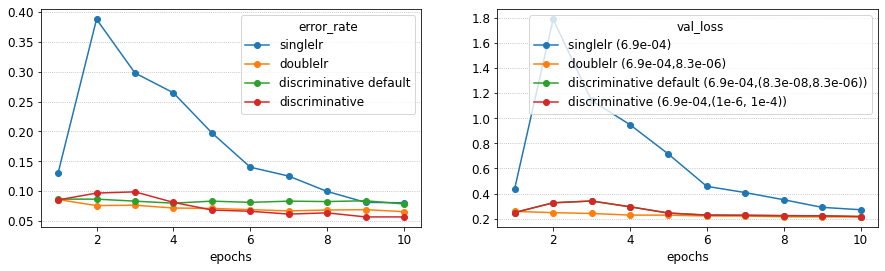

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

ax = axes[0]
ax.plot(df_metrics_singlelr['error_rate'], '-o', label='singlelr')
ax.plot(df_metrics_doublelr['error_rate'], '-o', label='doublelr')
ax.plot(df_metrics_discriminativelr_default['error_rate'], '-o', label='discriminative default')        
ax.plot(df_metrics_discriminativelr['error_rate'], '-o', label='discriminative')
        
ax.set_xlabel('epochs')
ax.grid(axis='y', linestyle=':')
ax.legend(title='error_rate')

ax = axes[1]
ax.plot(df_metrics_singlelr['val_loss'], '-o',
        label=f'singlelr ({single_lr.valley:.1e})')
ax.plot(df_metrics_doublelr['val_loss'], '-o',
        label=f'doublelr ({single_lr.valley:.1e},{doublelr.valley:.1e})')
ax.plot(df_metrics_discriminativelr['val_loss'], '-o',
        label=f'discriminative default ({single_lr.valley:.1e},({doublelr.valley/100:.1e},{doublelr.valley:.1e}))')
ax.plot(df_metrics_discriminativelr['val_loss'], '-o',
        label=f'discriminative ({single_lr.valley:.1e},(1e-6, 1e-4))')

ax.set_xlabel('epochs')
ax.grid(axis='y', linestyle=':')
ax.legend(title='val_loss')